#Import libraries & preparing data

In [ ]:
import pandas as pd
import numpy as np
import json

In [ ]:
f = open('/content/loan_data.json')

data = json.load(f)

In [ ]:
data[:2]

[{'Application_ID': 'LP001002',
  'Application_Status': 'Y',
  'Credit_History': 1,
  'Dependents': '0',
  'Education': 'Graduate',
  'Gender': 'Male',
  'Income': 'medium',
  'Married': 'No',
  'Property_Area': 'Urban',
  'Self_Employed': 'No'},
 {'Application_ID': 'LP001003',
  'Application_Status': 'N',
  'Credit_History': 1,
  'Dependents': '1',
  'Education': 'Graduate',
  'Gender': 'Male',
  'Income': 'medium',
  'Married': 'Yes',
  'Property_Area': 'Rural',
  'Self_Employed': 'No'}]

In [ ]:
df=pd.DataFrame.from_dict(data, orient='columns')

In [ ]:
df.head()

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y


# Queries

Find % of total applicants for each unique value of dependents.

In [ ]:
unique_values=df.Dependents.value_counts().index
total=df.Dependents.count()

idx=0

for i in df.Dependents.value_counts():
  print(unique_values[idx],":",round(i*100/total,2),'%')
  idx=idx+1

0 : 57.53 %
2 : 17.22 %
1 : 16.63 %
3+ : 8.61 %


Find the average number of dependents per applicant.

In [ ]:
#assuming 3+ dependents as "3" dependents

def convert_string(a):
  if(a=="0"):
    return 0
  elif(a=="1"):
    return 1
  elif(a=="2"):
    return 2
  
  return 3

In [ ]:
df['dependent']=df['Dependents'].apply(lambda x:convert_string(x))

total_dependents= df.dependent.count()
total_applicants= df.Application_ID.count()

print("avg dependents per applicant: ", total_dependents/total_applicants)

avg dependents per applicant:  1.0


Find the % of applications approved for self-employed applicants.

In [ ]:
print("approved %: ",round(df.Application_Status[df['Application_Status']=='Y'].count()*100/total_applicants,2),"%")

approved %:  67.91 %


What is the % of rejections for married male applicants?

In [ ]:
print("Rejection %: ",round(df.loc[(df.Gender=="Male")&(df.Married=="Yes")&(df.Application_Status=="N")]['Application_ID'].count()*100/total_applicants,2),"%")

Rejection %:  17.03 %


Which property area has the maximum approval ratio.


In [ ]:
df.groupby('Application_Status')['Property_Area'].value_counts()

Application_Status  Property_Area
N                   Urban             61
                    Rural             59
                    Semiurban         44
Y                   Semiurban        153
                    Urban            104
                    Rural             90
Name: Property_Area, dtype: int64

In [ ]:
def approval_rate(name):
  # print(df.loc[(df.Property_Area==name)].Application_Status.value_counts())
  y=df.loc[(df.Property_Area==name)].Application_Status.value_counts()[0]
  n=df.loc[(df.Property_Area==name)].Application_Status.value_counts()[1]
  print("-------------")
  print("approval rate of ",name,": ",y*100/(y+n),"%")
  print("-------------")

In [ ]:
df.Property_Area.value_counts()

Semiurban    197
Urban        165
Rural        149
Name: Property_Area, dtype: int64

In [ ]:
df.Property_Area.value_counts().index[0]

'Semiurban'

In [ ]:
pd.Series(df.Property_Area.value_counts().index).apply(lambda x:approval_rate(x))

-------------
approval rate of  Semiurban :  77.66497461928934 %
-------------
-------------
approval rate of  Urban :  63.03030303030303 %
-------------
-------------
approval rate of  Rural :  60.40268456375839 %
-------------


0    None
1    None
2    None
dtype: object



```
Highest approval rate: Semiurban area, 77% approval
```



Find average dependents per income group.


In [ ]:
df.groupby('Income')['dependent'].sum()/df.groupby('Income')['Application_ID'].count()

Income
high      0.888889
low       0.641026
medium    0.922280
dtype: float64

In [ ]:
# df.groupby('Income')['Application_ID'].count()

In [ ]:
# df.groupby('Income')['dependent'].sum()

# Simple predictive model to assess whether a loan application will be approved or rejected 

## Data preparation

In [ ]:
df.head(5)

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status,dependent
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y,0
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N,1
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y,0
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y,0
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y,0


### Check for null values

In [ ]:
#check for null values
df.count()

Application_ID        511
Gender                511
Married               511
Dependents            511
Education             511
Self_Employed         511
Credit_History        511
Property_Area         511
Income                511
Application_Status    511
dependent             511
dtype: int64

In [ ]:
#no null values are there

### Remove unnecessary columns

In [ ]:
data=df.copy()
data.head()

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status,dependent
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y,0
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N,1
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y,0
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y,0
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y,0


In [ ]:
data=data.drop(columns=['Application_ID','Dependents'])

In [ ]:
data.head()

,Gender,Married,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status,dependent
0,Male,No,Graduate,No,1,Urban,medium,Y,0
1,Male,Yes,Graduate,No,1,Rural,medium,N,1
2,Male,Yes,Graduate,Yes,1,Urban,low,Y,0
3,Male,Yes,Not Graduate,No,1,Urban,low,Y,0
4,Male,No,Graduate,No,1,Urban,medium,Y,0


### convert categorical values from string type to int 

In [ ]:
#for binary categories, we would use 0,1
#for multiple (>2), we will use one hot encoding

#### binary:

In [ ]:
data.Gender.value_counts()

Male      420
Female     91
Name: Gender, dtype: int64

In [ ]:
data['Gender']=data['Gender'].apply(lambda x: 1 if x=="Female" else 0) #Female - 1, Male - 0

In [ ]:
data.Married.value_counts()

Yes    331
No     180
Name: Married, dtype: int64

In [ ]:
data['Married']=data['Married'].apply(lambda x: 1 if x=="Yes" else 0) 

In [ ]:
data.Education.value_counts()

Graduate        401
Not Graduate    110
Name: Education, dtype: int64

In [ ]:
data['Education']=data['Education'].apply(lambda x: 1 if x=="Graduate" else 0) 

In [ ]:
data.Application_Status.value_counts()

Y    347
N    164
Name: Application_Status, dtype: int64

In [ ]:
data['Application_Status']=data['Application_Status'].apply(lambda x: 1 if x=="Y" else 0) 

In [ ]:
data.Self_Employed.value_counts()

No     441
Yes     70
Name: Self_Employed, dtype: int64

In [ ]:
data['Self_Employed']=data['Self_Employed'].apply(lambda x: 1 if x=="Yes" else 0) 

In [ ]:
data.head(78)

,Gender,Married,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status,dependent
0,0,0,1,0,1,Urban,medium,1,0
1,0,1,1,0,1,Rural,medium,0,1
2,0,1,1,1,1,Urban,low,1,0
3,0,1,0,0,1,Urban,low,1,0
4,0,0,1,0,1,Urban,medium,1,0
...,...,...,...,...,...,...,...,...,...
73,1,1,1,0,1,Urban,low,0,2
74,0,1,1,0,1,Urban,low,1,1
75,0,0,1,0,1,Semiurban,low,1,0
76,0,1,1,0,1,Semiurban,low,1,0


#### multiple (>2):

In [ ]:
data=data.join(pd.get_dummies(df.Property_Area,prefix='property_area'))

In [ ]:
data=data.join(pd.get_dummies(df.Income,prefix='income'))

In [ ]:
data.head()

,Gender,Married,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status,dependent,property_area_Rural,property_area_Semiurban,property_area_Urban,income_high,income_low,income_medium
0,0,0,1,0,1,Urban,medium,1,0,0,0,1,0,0,1
1,0,1,1,0,1,Rural,medium,0,1,1,0,0,0,0,1
2,0,1,1,1,1,Urban,low,1,0,0,0,1,0,1,0
3,0,1,0,0,1,Urban,low,1,0,0,0,1,0,1,0
4,0,0,1,0,1,Urban,medium,1,0,0,0,1,0,0,1


In [ ]:
data=data.drop(columns=['Property_Area','Income'])

## Split data

(array([164.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 347.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

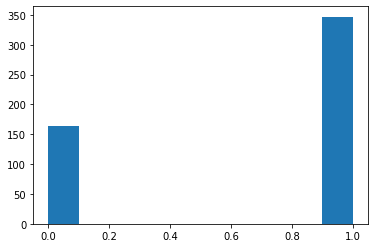

In [ ]:
import matplotlib.pyplot as plt

plt.hist(data.Application_Status)

In [ ]:
X= data.drop(columns=['Application_Status'])
Y= data['Application_Status']

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=data['Application_Status'])

In [ ]:
# using the random state for reproducibility

as the data isn't very well balanced hence we use stratify to maintain same ratio of Y's and N's

(array([115.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 242.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

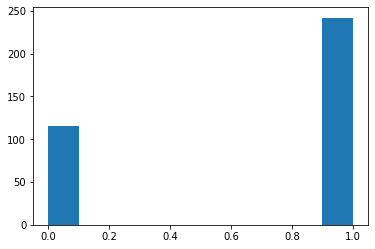

In [ ]:
plt.hist(y_train)

(array([ 49.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 105.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

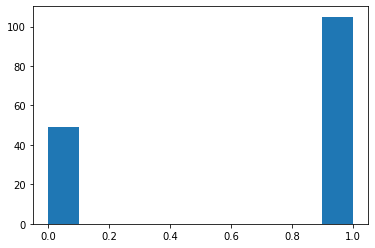

In [ ]:
plt.hist(y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [ ]:
tree= DecisionTreeClassifier(random_state=24) 
forest= RandomForestClassifier(random_state=24)
knn= KNeighborsClassifier()
svm= SVC(random_state=24)
xboost= XGBClassifier(random_state=24)
lr = LogisticRegression(random_state=24)
nb = GaussianNB()

models= [tree, forest, knn, svm, xboost,lr,nb]
acc=[]
max_acc=0

for model in models:
    model.fit(X_train, y_train) 
    y_pred= model.predict(X_test) 
    accuracy= accuracy_score(y_test, y_pred) 
    clf_report= classification_report(y_test, y_pred) 
    print(f"The accuracy of model {type(model).__name__} is {accuracy*100:.2f}")

    if(accuracy>max_acc):
      model_name=type(model).__name__
      max_acc=accuracy
      best_model=model

    print(clf_report)
    print("\n")

print(f"Highest accuracy has been obtained using model {model_name}, accuracy:{max_acc*100:.2f}%.")

The accuracy of model DecisionTreeClassifier is 76.62
              precision    recall  f1-score   support

           0       0.65      0.57      0.61        49
           1       0.81      0.86      0.83       105

    accuracy                           0.77       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.76      0.77      0.76       154



The accuracy of model RandomForestClassifier is 76.62
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        49
           1       0.80      0.88      0.84       105

    accuracy                           0.77       154
   macro avg       0.73      0.70      0.71       154
weighted avg       0.76      0.77      0.76       154



The accuracy of model KNeighborsClassifier is 77.27
              precision    recall  f1-score   support

           0       0.75      0.43      0.55        49
           1       0.78      0.93      0.85       105

    accuracy      



```
Highest accuracy has been obtained using model SVC, accuracy:84.42%.
```



In [ ]:
best_model

SVC(random_state=24)

## Prediction

In [ ]:
def take_inputs():
  x_pred=[]
  print("Gender: if Male enter 0, if Female enter 1")
  gender=int(input())
  x_pred.append(gender)

  print("Married: Yes: 1 No:0")
  married=int(input())
  x_pred.append(married)

  print("Education: graduated: 1 Not graduated:0")
  edu=int(input())
  x_pred.append(edu)

  print("Selfemployed? Yes 1, no 0")
  self_employed=int(input())
  x_pred.append(self_employed)

  print("Credit History? Yes 1, No 0")
  credit_history=int(input())
  x_pred.append(credit_history)

  print("dependent?, if 0: enter 0, if 1: enter 1, if 2: enter 2, if 3+:enter 3")
  dependent=int(input())
  x_pred.append(dependent)

  print("property area type: 1: rural, 2: semi urban, 3: urban")
  area=int(input())

  if(area ==1):
    x_pred=x_pred+[1,0,0]

  elif(area==2):
    x_pred=x_pred+[0,1,0]

  elif(area==3):
    x_pred=x_pred+[0,0,1]
  
  print("income type: 1: high, 2:low, 3: medium")
  income=int(input())  
  if(income==1):
    x_pred=x_pred+[1,0,0]

  elif(income==2):
    x_pred=x_pred+[0,1,0]
  elif(income==3):
    x_pred=x_pred+[0,0,1]

  return x_pred

In [ ]:
def loan_application_status():
  x_pred=take_inputs()
  y_pred=best_model.predict([x_pred])[0]
  print("******************************************")
  if(y_pred==0):
    print("loan application will be rejected")
  else:
    print("loan application will be approved")
  
  print("******************************************")


In [ ]:
loan_application_status()

Gender: if Male enter 0, if Female enter 1
1
Married: Yes: 1 No:0
1
Education: graduated: 1 Not graduated:0
1
Selfemployed? Yes 1, no 0
1
Credit History? Yes 1, No 0
1
dependent?, if 0: enter 0, if 1: enter 1, if 2: enter 2, if 3+:enter 3
2
property area type: 1: rural, 2: semi urban, 3: urban
3
income type: 1: high, 2:low, 3: medium
1
******************************************
loan application will be approved
******************************************


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
loan_application_status()

Gender: if Male enter 0, if Female enter 1
1
Married: Yes: 1 No:0
1
Education: graduated: 1 Not graduated:0
0
Selfemployed? Yes 1, no 0
0
Credit History? Yes 1, No 0
0
dependent?, if 0: enter 0, if 1: enter 1, if 2: enter 2, if 3+:enter 3
3
property area type: 1: rural, 2: semi urban, 3: urban
1
income type: 1: high, 2:low, 3: medium
2
******************************************
loan application will be rejected
******************************************


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
